In [1]:
# !pip install tensorflow


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\APZIVA\Project 5\stock_price_data.csv')

In [4]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,31-Mar-21,291.02,294.00,294.42,290.26,47.00M,-0.76%
1,30-Mar-21,293.25,294.86,295.72,291.50,38.81M,-0.02%
2,29-Mar-21,293.30,289.72,294.09,289.26,43.68M,0.71%
3,26-Mar-21,291.22,288.63,292.75,288.32,56.07M,1.59%
4,25-Mar-21,286.66,286.50,287.03,283.85,35.22M,0.30%


In [5]:
data = data[['Date','Price']]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    311 non-null    object 
 1   Price   311 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


In [7]:
# change 'Date' to a datetime object
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    311 non-null    datetime64[ns]
 1   Price   311 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.0 KB


In [9]:
# sort data in ascending order by date

data = data.sort_values(by='Date')

In [10]:
data.head()

,Date,Price
310,2020-01-03,255.00
309,2020-01-06,253.90
308,2020-01-08,259.15
307,2020-01-09,257.99
306,2020-01-10,258.19


In [11]:
data.tail()

,Date,Price
4,2021-03-25,286.66
3,2021-03-26,291.22
2,2021-03-29,293.30
1,2021-03-30,293.25
0,2021-03-31,291.02


In [12]:
# **create train_data**
train_data = data[data.Date <= '2020-12-31']

In [13]:
print(train_data.Date.min())
print(train_data.Date.max())

2020-01-03 00:00:00
2020-12-30 00:00:00


In [14]:
def lineplot(x,y,data_,title_):
    sns.set(rc = {'figure.figsize':(15,8)})
    # Bigger than normal fonts
    sns.set(font_scale=1.5)
    sns.set_style('darkgrid')
    chart = sns.lineplot(x = x, y = y, data = data_)
    chart.set(title=title_)
    plt.show()

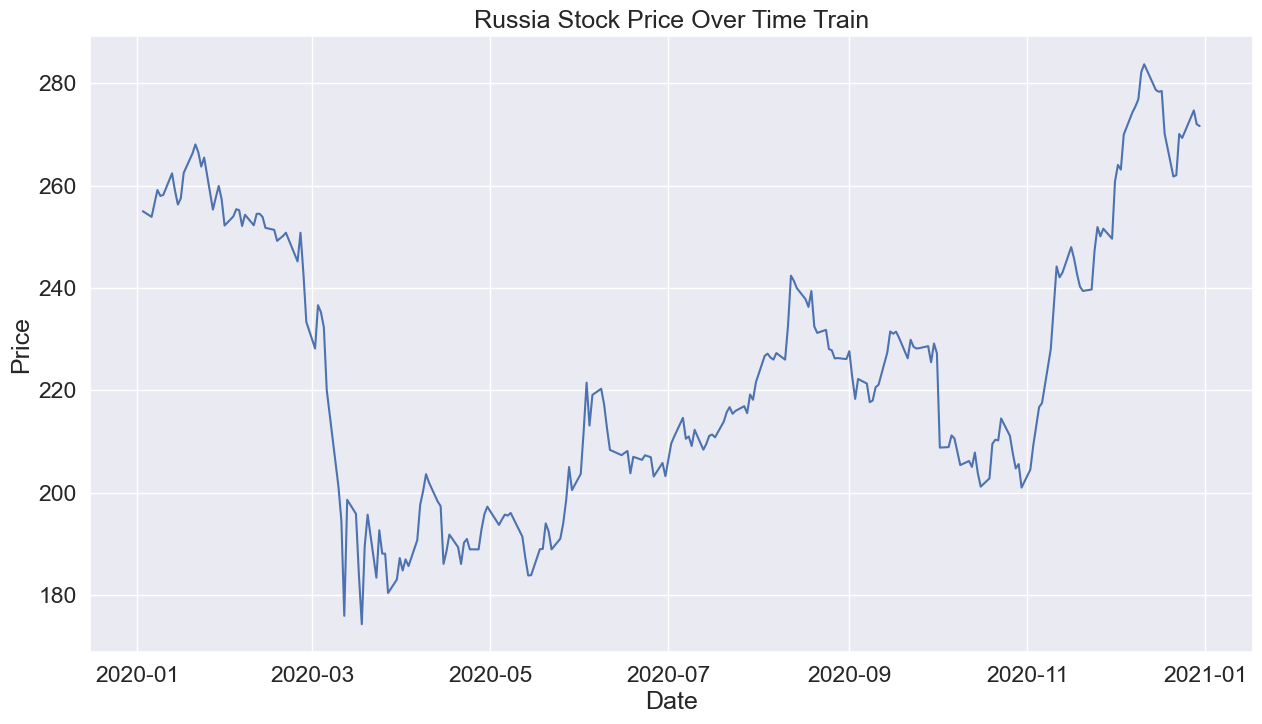

In [15]:
lineplot(x='Date',y='Price',data_=train_data,title_='Russia Stock Price Over Time Train')

In [16]:
# **create test_data**
test_data =data[data.Date > '2020-12-31']

In [17]:
print('min',test_data.Date.min())
print('max  ',test_data.max())

min 2021-01-04 00:00:00
max   Date     2021-03-31 00:00:00
Price                  293.3
dtype: object


In [18]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data[['Price']])

In [19]:
# Create a function to prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [20]:
scaled_train_data.shape

(250, 1)

In [21]:
time_step = 60
X_train, y_train = create_dataset(scaled_train_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


In [22]:
X_train.shape

(189, 60, 1)

In [23]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Forecast the first quarter of 2021
n_future_days = 60  # Assuming there are 60 trading days in the first quarter of 2021
x_input = scaled_train_data[-time_step:].reshape(1, -1)#=>scaled_train_data[-60:]
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Generate predictions for the next 60 days
lst_output = []
i = 0
while i < n_future_days:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Transform the forecasted data back to original scale
forecasted_stock_prices = scaler.inverse_transform(lst_output)

# Create a date range for the forecasted data
last_date = train_data['Date'].max()
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future_days, freq='B')  # Business days


C:\Users\dgarb\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0263


In [24]:
# forecast_dates

In [25]:
type(forecast_dates)
# list(forecast_dates)
type(forecasted_stock_prices)
forecasted_stock_prices = forecasted_stock_prices.reshape(-1)
# array_1d = array_2d.reshape(-1)
# print(array_1d)


In [26]:
dict_forecast = {'forecast_dates':list(forecast_dates) , 'forecasted_stock_prices':list(forecasted_stock_prices)}

In [27]:
forecast_df = pd.DataFrame(dict_forecast)

In [28]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   forecast_dates           60 non-null     datetime64[ns]
 1   forecasted_stock_prices  60 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [29]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 60 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    61 non-null     datetime64[ns]
 1   Price   61 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


In [30]:
comparison = test_data.merge(forecast_df, left_on='Date', right_on='forecast_dates', how='inner')

comparison.head()

,Date,Price,forecast_dates,forecasted_stock_prices
0,2021-01-04,272.00,2021-01-04,269.009415
1,2021-01-05,275.20,2021-01-05,268.812119
2,2021-01-06,272.93,2021-01-06,268.597443
3,2021-01-08,283.64,2021-01-08,268.148713
4,2021-01-11,289.49,2021-01-11,267.924113


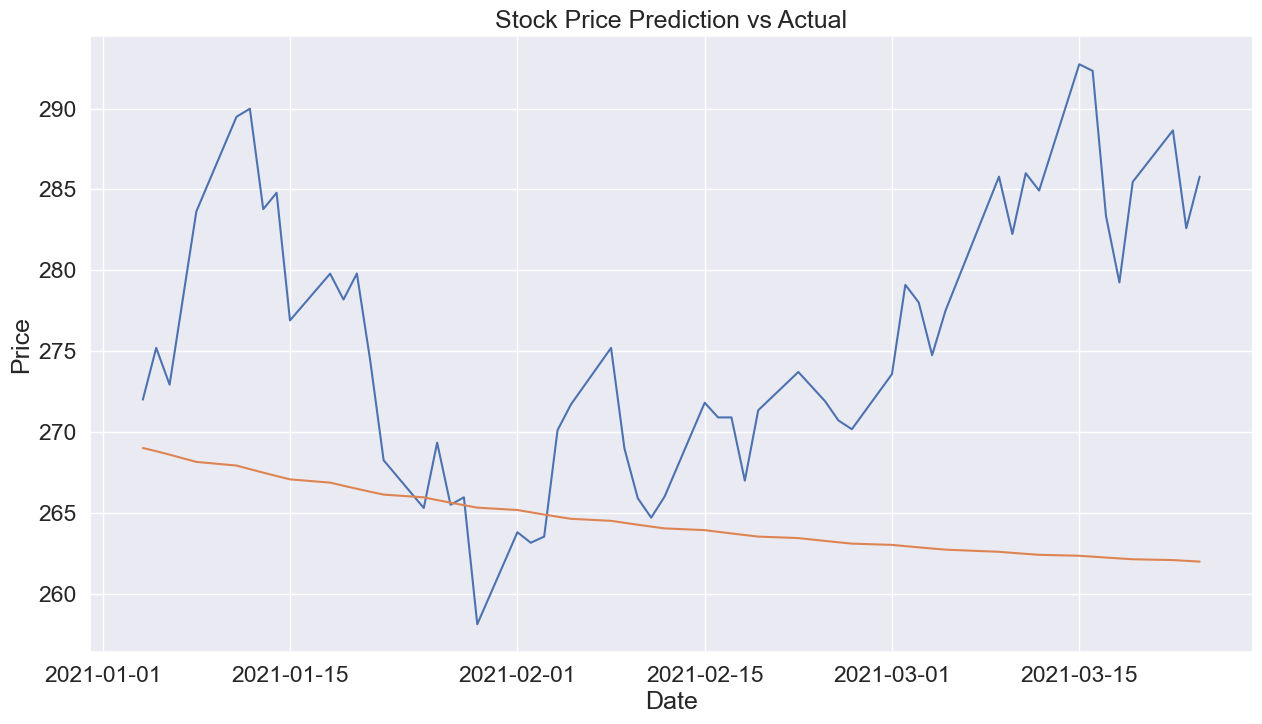

In [78]:
sns.lineplot(x='Date', y='Price', data=comparison)
sns.lineplot(x='Date', y='forecasted_stock_prices', data=comparison)
plt.title('Stock Price Prediction vs Actual')
plt.show()

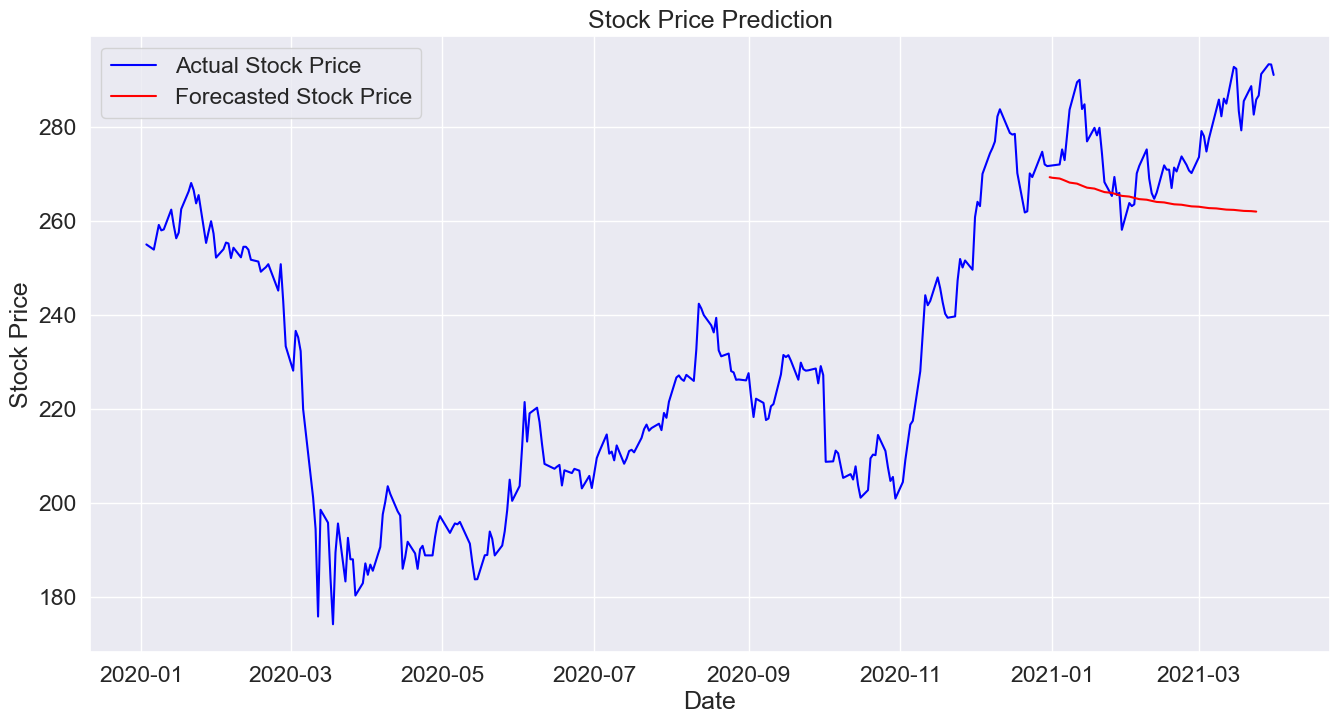

In [34]:
# Plot the forecasted stock prices using Seaborn
sns.set_style('darkgrid')
plt.figure(figsize=(16, 8))
sns.lineplot(x=data['Date'], y=data['Price'], label='Actual Stock Price', color='blue')
sns.lineplot(x=forecast_dates, y=forecasted_stock_prices.flatten(), label='Forecasted Stock Price', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

In [72]:
def calculate_mape(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    return np.mean(np.abs((actual - forecast) / actual)) * 100

In [74]:
calculate_mape(comparison.Price, comparison.forecasted_stock_prices)

4.077100162536898